# Dog Breed Identification

### Import libraries

In [1]:
import numpy as np
np.set_printoptions(precision=6, suppress=True, formatter={'float': '{: 0.2f}'.format})
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import os
import re
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset
from torchvision import transforms, models
import torch.optim as optim

### Dataset Preprocessing

In [3]:
class DogBreedDataset(Dataset):
    """ Custom dataset for dog breed images """
    def __init__(self, csv_file, root_dir, breed_to_idx, transform=None):
        self.labels_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.breed_to_idx = breed_to_idx
        self.transform = transform
    def __len__(self):
        return len(self.labels_frame)
    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.labels_frame.iloc[idx, 0] + '.jpg')
        image = Image.open(img_name).convert('RGB')
        label = self.breed_to_idx.get(self.labels_frame.iloc[idx, 1], -1)
        if self.transform:
            image = self.transform(image)
        return image, label # Return the image and its label index
    
def create_data_loaders(labels_file_path, train_dir, breed_to_idx, batch_size,val_split=0.3):
    """ Define transformations for the images """
    data_transforms = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    full_dataset = DogBreedDataset(labels_file_path, train_dir, breed_to_idx, transform=data_transforms)
    train_size = int((1 - val_split) * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
    # Create data loaders for training and validation sets
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader

def plot_breed_distribution(labels_df):
    """ Plotting the distribution of breeds """
    breed_counts = labels_df['breed'].value_counts()
    total = breed_counts.sum()
    categories = len(breed_counts)
    breed_counts_array = breed_counts.values
    norm = plt.Normalize(breed_counts_array.min(), breed_counts_array.max())
    colors = plt.cm.viridis(norm(breed_counts_array))
    plt.figure(figsize=(12, 6))
    bars = plt.bar(range(categories), breed_counts_array, color=colors, width=0.8)
    plt.title(f'Dog Breed Distribution - Total: {total}, Categories: {categories}', fontsize=16)
    plt.xlabel('Dog Breed Category', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, ax=plt.gca(), orientation='vertical')
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

def visualize_dataset(train_loader, row, col, breed_to_idx):
    """ Plotting images in a grid """
    idx_to_breed = {v: k for k, v in breed_to_idx.items()}
    dataiter = iter(train_loader)
    images, labels = dataiter.next()
    plt.figure(figsize=(15, (15/col) * row))
    for i in range(row*col):
        if i == len(images):
            break
        plt.subplot(row, col, i+1)
        img = images[i].numpy().transpose((1, 2, 0))
        img = np.clip(img, 0, 1)  
        plt.imshow(img)
        plt.title(f'label: {labels[i].item()}') 
        plt.axis('off')
    plt.show()

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
LABELS_FILE_PATH = './dog-breed-identification/labels.csv'
TRAIN_DIR = './dog-breed-identification/train'
BATCH_SIZE = 32
labels_df = pd.read_csv(LABELS_FILE_PATH)
breed_to_idx = {breed: idx for idx,
                breed in enumerate(labels_df['breed'].unique())}
NUM_BREEDS = len(breed_to_idx)
train_loader, val_loader = create_data_loaders(
    LABELS_FILE_PATH, TRAIN_DIR, breed_to_idx, BATCH_SIZE)

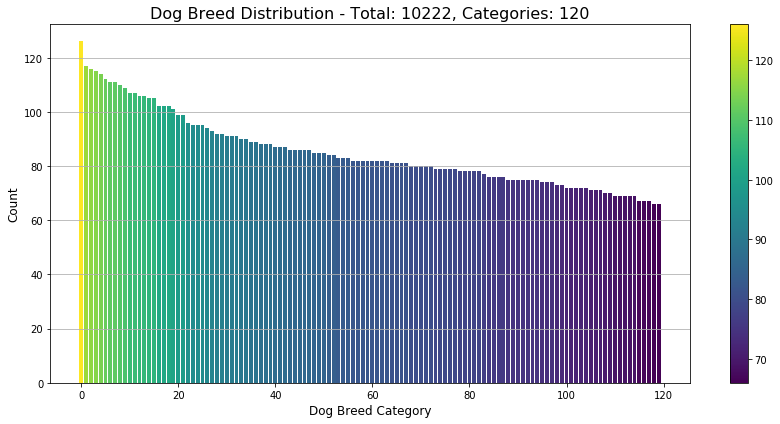

In [6]:
plot_breed_distribution(labels_df)

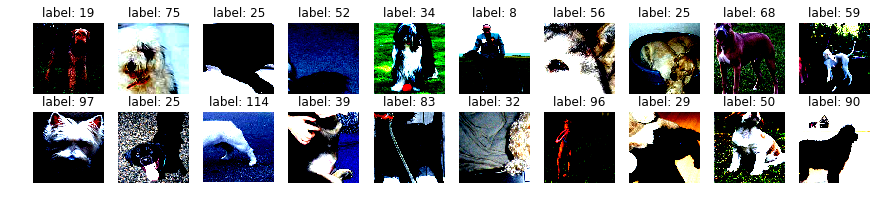

In [7]:
visualize_dataset(train_loader, 2, 10, breed_to_idx)

### Early Stopping Mechanism and Training Process

In [51]:
# Define an EarlyStopping class to control training early termination
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.best_loss = float('inf')   
        self.early_stop = False
        self.counter = 0

    def __call__(self, train_loss, model, model_path):
        # Check if current training loss is improving
        if train_loss < self.best_loss - self.delta:
            self.best_loss = train_loss
            self.save_checkpoint(train_loss, model, model_path)
            self.counter = 0
        else:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
                
    def save_checkpoint(self, train_loss, model, model_path):
        if self.verbose:
            print(f'Training loss decreased. Saving model ...')
        torch.save(model.state_dict(), model_path)

# Function to train a model
def train_model(model, device, train_loader, val_loader, num_epochs, lr, model_path, patience=7, log_file_path='train_logs/train001.txt'):
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(
        [param for param in model.parameters() if param.requires_grad], lr=lr)

    fp = open(log_file_path, 'w')
    fp.close()

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        avg_train_loss = total_train_loss / len(train_loader)
        train_accuracy = 100 * correct_train / total_train

        model.eval()
        total_val_loss = 0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                total_val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
        avg_val_loss = total_val_loss / len(val_loader)
        val_accuracy = 100 * correct_val / total_val
        with open(log_file_path, 'a') as log_file:
            log_file.write(
                f'Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%\n')
        print(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}% - Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')
        early_stopping(avg_train_loss, model, model_path)
        if early_stopping.early_stop:
            print("Early stopping")
            break
    return model

# Function to plot accuracy
def plot_accuracy(log_file_path):
    train_accuracies, val_accuracies = [], []
    total_epochs, best_train_acc, best_val_acc, best_epoch_train_acc, best_epoch_val_acc = None, 0, 0, None, None
    with open(log_file_path, 'r') as file:
        for line in file:
            match = re.search(r'Epoch (\d+)/(\d+) - Train Loss: [\d\.]+, Train Acc: ([\d\.]+)%, Val Loss: [\d\.]+, Val Acc: ([\d\.]+)%', line)
            if match:
                epoch = int(match.group(1))
                total_epochs = int(match.group(2))
                train_acc = float(match.group(3))
                val_acc = float(match.group(4))
                train_accuracies.append(train_acc)
                val_accuracies.append(val_acc)
                if train_acc > best_train_acc:
                    best_train_acc = train_acc
                    best_epoch_train_acc = epoch
                if val_acc > best_val_acc:
                    best_val_acc = val_acc
                    best_epoch_val_acc = epoch

    early_stopping_epoch = epoch if epoch < total_epochs else None
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label=f'Train Accuracy (Best: {best_train_acc}% at Epoch {best_epoch_train_acc})')
    plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label=f'Validation Accuracy (Best: {best_val_acc}% at Epoch {best_epoch_val_acc})')
    if early_stopping_epoch is not None:
        plt.axvline(x=early_stopping_epoch, color='r', linestyle='--', label=f'Early Stopping at Epoch {early_stopping_epoch}')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.xlim(1, total_epochs)
    plt.legend()
    plt.grid()
    plt.show()

# Function to plot loss
def plot_loss(log_file_path):
    train_losses, val_losses = [], []
    total_epochs, best_train_loss, best_val_loss, best_epoch_train_loss, best_epoch_val_loss = None, float('inf'), float('inf'), None, None
    with open(log_file_path, 'r') as file:
        for line in file:
            match = re.search(r'Epoch (\d+)/(\d+) - Train Loss: ([\d\.]+), Train Acc: [\d\.]+%, Val Loss: ([\d\.]+), Val Acc: ([\d\.]+)%', line)
            if match:
                epoch = int(match.group(1))
                total_epochs = int(match.group(2))
                train_loss = float(match.group(3))
                val_loss = float(match.group(4))
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                if train_loss < best_train_loss:
                    best_train_loss = train_loss
                    best_epoch_train_loss = epoch
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_epoch_val_loss = epoch

    early_stopping_epoch = epoch if epoch < total_epochs else None
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label=f'Train Loss (Best: {best_train_loss} at Epoch {best_epoch_train_loss})')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label=f'Validation Loss (Best: {best_val_loss} at Epoch {best_epoch_val_loss})')
    if early_stopping_epoch is not None:
        plt.axvline(x=early_stopping_epoch, color='r', linestyle='--', label=f'Early Stopping at Epoch {early_stopping_epoch}')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.xlim(1, total_epochs)
    plt.legend()
    plt.grid()
    plt.show()

### CNN Architecture Definition

In [9]:
# Define a class for Squeeze-and-Excitation (SE) Block
class SEBlock(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c) # Global average pooling
        y = self.fc(y).view(b, c, 1, 1) # Fully connected layers
        return x * y.expand_as(x)  # Scale input by SE attention weights

# Define a class for the Dog Breed Classification CNN
class DogBreedCNN(nn.Module):
    def __init__(self, num_breeds, use_seblock=True, use_leaky_relu=True, use_dropout=True):
        super(DogBreedCNN, self).__init__()
        resnet = models.resnet101(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad = False
        if use_seblock:
            layers = list(resnet.children())[:-2]
            layers.append(SEBlock(2048)) # Append an SEBlock
        else:
            layers = list(resnet.children())[:-2]
        self.features = nn.Sequential(*layers)
        num_features = 2048 
        classifier_layers = [
            nn.AdaptiveAvgPool2d((1, 1)), # Adaptive average pooling
            nn.Flatten(),
            nn.Linear(num_features, 512)  # Linear layer for feature transformation
        ]
        if use_leaky_relu:
            classifier_layers.append(nn.LeakyReLU(0.1))
        if use_dropout:
            classifier_layers.append(nn.Dropout(0.5))
        classifier_layers.append(nn.Linear(512, num_breeds))
        self.classifier = nn.Sequential(*classifier_layers)
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

### Model Training

In [18]:
num_epochs = 50
lr = 0.0005
patience = 10

name = "model_all_features"
model_path = name + '.pth'
log_file = name + '.txt'
model_all_features = DogBreedCNN(num_breeds=NUM_BREEDS, use_seblock=True, use_leaky_relu=True, use_dropout=True).to(device)
trained_model = train_model(model_all_features, device, train_loader, val_loader, num_epochs, lr, model_path, patience, log_file_path=log_file)

Epoch 1/50 - Train Loss: 4.7695, Train Acc: 1.68% - Val Loss: 4.6886, Val Acc: 8.50%
Training loss decreased. Saving model ...
Epoch 2/50 - Train Loss: 4.6114, Train Acc: 6.99% - Val Loss: 4.5733, Val Acc: 13.73%
Training loss decreased. Saving model ...
Epoch 3/50 - Train Loss: 4.4525, Train Acc: 12.72% - Val Loss: 4.4150, Val Acc: 16.99%
Training loss decreased. Saving model ...
Epoch 4/50 - Train Loss: 4.2544, Train Acc: 18.45% - Val Loss: 4.1838, Val Acc: 24.84%
Training loss decreased. Saving model ...
Epoch 5/50 - Train Loss: 3.9584, Train Acc: 25.44% - Val Loss: 3.8779, Val Acc: 34.64%
Training loss decreased. Saving model ...
Epoch 6/50 - Train Loss: 3.6324, Train Acc: 32.42% - Val Loss: 3.5296, Val Acc: 37.91%
Training loss decreased. Saving model ...
Epoch 7/50 - Train Loss: 3.2311, Train Acc: 37.18% - Val Loss: 3.1086, Val Acc: 38.56%
Training loss decreased. Saving model ...
Epoch 8/50 - Train Loss: 2.8245, Train Acc: 44.30% - Val Loss: 2.8028, Val Acc: 41.83%
Training loss

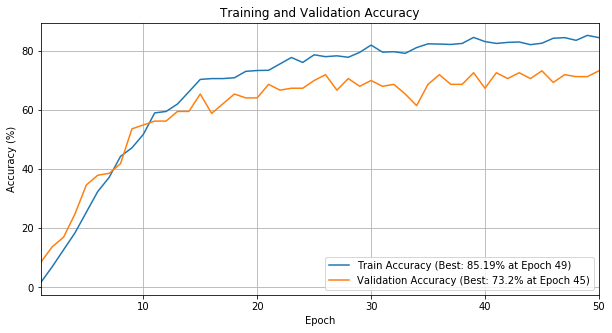

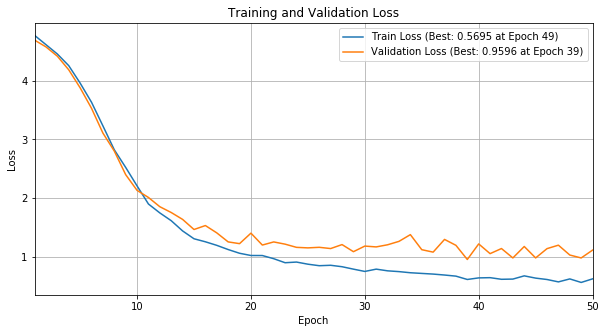

In [52]:
name = "model_all_features"
log_file = name + '.txt'
plot_accuracy(log_file)
plot_loss(log_file)

In [19]:
name = "model_no_leaky_relu"
model_path = name + '.pth'
log_file = name + '.txt'
model_no_leaky_relu = DogBreedCNN(num_breeds=NUM_BREEDS, use_seblock=True, use_leaky_relu=False, use_dropout=True).to(device)
trained_model = train_model(model_no_leaky_relu, device, train_loader, val_loader, num_epochs, lr, model_path, patience, log_file_path=log_file)

Epoch 1/50 - Train Loss: 4.7434, Train Acc: 2.17% - Val Loss: 4.6000, Val Acc: 12.42%
Training loss decreased. Saving model ...
Epoch 2/50 - Train Loss: 4.4727, Train Acc: 13.84% - Val Loss: 4.3757, Val Acc: 26.80%
Training loss decreased. Saving model ...
Epoch 3/50 - Train Loss: 4.1847, Train Acc: 24.25% - Val Loss: 4.1168, Val Acc: 31.37%
Training loss decreased. Saving model ...
Epoch 4/50 - Train Loss: 3.8285, Train Acc: 33.19% - Val Loss: 3.7387, Val Acc: 32.03%
Training loss decreased. Saving model ...
Epoch 5/50 - Train Loss: 3.3427, Train Acc: 41.86% - Val Loss: 3.1433, Val Acc: 42.48%
Training loss decreased. Saving model ...
Epoch 6/50 - Train Loss: 2.8439, Train Acc: 48.78% - Val Loss: 2.8307, Val Acc: 50.33%
Training loss decreased. Saving model ...
Epoch 7/50 - Train Loss: 2.3544, Train Acc: 56.81% - Val Loss: 2.3633, Val Acc: 49.67%
Training loss decreased. Saving model ...
Epoch 8/50 - Train Loss: 1.9637, Train Acc: 62.54% - Val Loss: 2.0582, Val Acc: 56.21%
Training lo

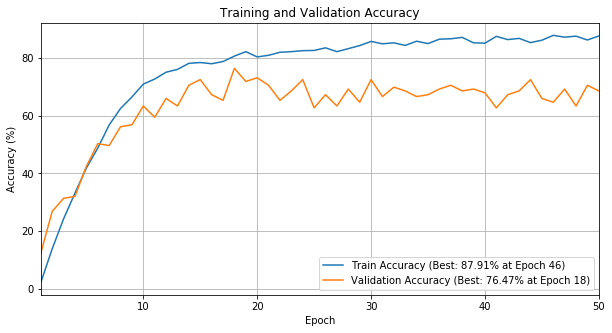

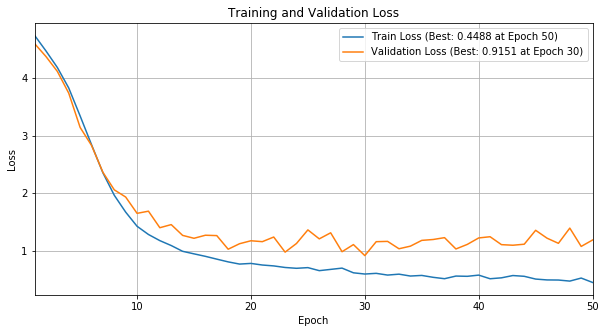

In [53]:
name = "model_no_leaky_relu"
log_file = name + '.txt'
plot_accuracy(log_file)
plot_loss(log_file)

In [20]:
name = "model_no_dropout"
model_path = name + '.pth'
log_file = name + '.txt'
model_no_dropout = DogBreedCNN(num_breeds=NUM_BREEDS, use_seblock=True, use_leaky_relu=True, use_dropout=False).to(device)
trained_model = train_model(model_no_dropout, device, train_loader, val_loader, num_epochs, lr, model_path, patience, log_file_path=log_file)

Epoch 1/50 - Train Loss: 4.7438, Train Acc: 3.35% - Val Loss: 4.6427, Val Acc: 13.73%
Training loss decreased. Saving model ...
Epoch 2/50 - Train Loss: 4.4998, Train Acc: 13.98% - Val Loss: 4.3883, Val Acc: 20.26%
Training loss decreased. Saving model ...
Epoch 3/50 - Train Loss: 4.1979, Train Acc: 30.68% - Val Loss: 4.1104, Val Acc: 31.37%
Training loss decreased. Saving model ...
Epoch 4/50 - Train Loss: 3.7788, Train Acc: 42.28% - Val Loss: 3.7284, Val Acc: 34.64%
Training loss decreased. Saving model ...
Epoch 5/50 - Train Loss: 3.2703, Train Acc: 47.17% - Val Loss: 3.2138, Val Acc: 40.52%
Training loss decreased. Saving model ...
Epoch 6/50 - Train Loss: 2.7056, Train Acc: 56.11% - Val Loss: 2.6469, Val Acc: 48.37%
Training loss decreased. Saving model ...
Epoch 7/50 - Train Loss: 2.1717, Train Acc: 65.90% - Val Loss: 2.3070, Val Acc: 49.67%
Training loss decreased. Saving model ...
Epoch 8/50 - Train Loss: 1.7684, Train Acc: 70.09% - Val Loss: 1.8942, Val Acc: 60.13%
Training lo

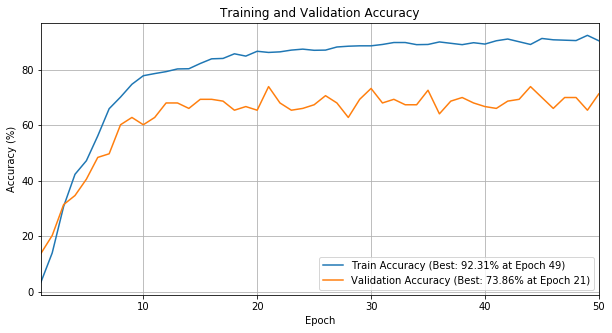

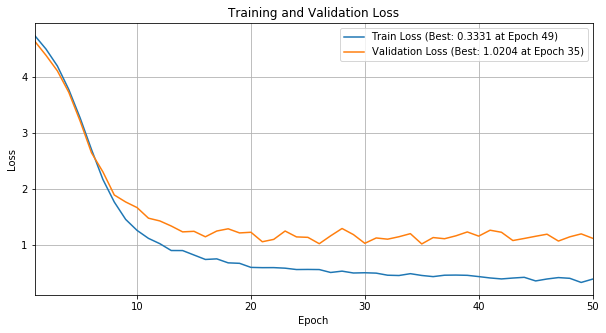

In [54]:
name = "model_no_dropout"
log_file = name + '.txt'
plot_accuracy(log_file)
plot_loss(log_file)

In [21]:
name = "model_no_seblock"
model_path = name + '.pth'
log_file = name + '.txt'
model_no_seblock = DogBreedCNN(num_breeds=NUM_BREEDS, use_seblock=False, use_leaky_relu=True, use_dropout=True).to(device)
trained_model = train_model(model_no_seblock, device, train_loader, val_loader, num_epochs, lr, model_path, patience, log_file_path=log_file)

Epoch 1/50 - Train Loss: 4.7547, Train Acc: 1.82% - Val Loss: 4.6183, Val Acc: 7.84%
Training loss decreased. Saving model ...
Epoch 2/50 - Train Loss: 4.4879, Train Acc: 9.08% - Val Loss: 4.3722, Val Acc: 21.57%
Training loss decreased. Saving model ...
Epoch 3/50 - Train Loss: 4.2162, Train Acc: 16.77% - Val Loss: 4.1333, Val Acc: 25.49%
Training loss decreased. Saving model ...
Epoch 4/50 - Train Loss: 3.9306, Train Acc: 22.57% - Val Loss: 3.8835, Val Acc: 29.41%
Training loss decreased. Saving model ...
Epoch 5/50 - Train Loss: 3.6177, Train Acc: 33.05% - Val Loss: 3.5908, Val Acc: 39.22%
Training loss decreased. Saving model ...
Epoch 6/50 - Train Loss: 3.3246, Train Acc: 37.25% - Val Loss: 3.3225, Val Acc: 39.22%
Training loss decreased. Saving model ...
Epoch 7/50 - Train Loss: 3.0179, Train Acc: 42.56% - Val Loss: 3.1076, Val Acc: 43.79%
Training loss decreased. Saving model ...
Epoch 8/50 - Train Loss: 2.7528, Train Acc: 46.19% - Val Loss: 2.7739, Val Acc: 49.02%
Training loss

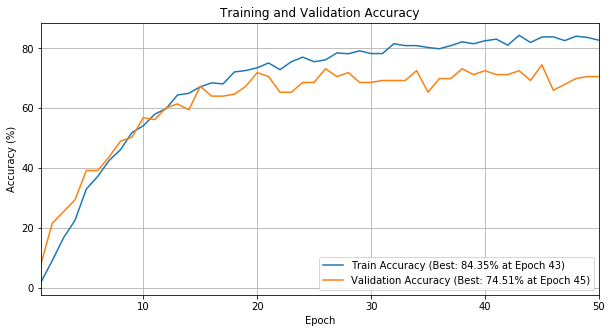

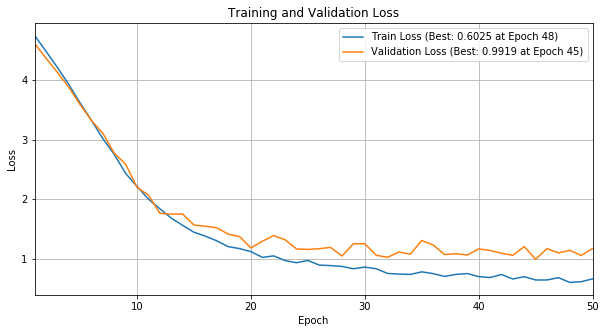

In [55]:
name = "model_no_seblock"
log_file = name + '.txt'
plot_accuracy(log_file)
plot_loss(log_file)

In [22]:
name = "model_only_leaky_relu"
model_path = name + '.pth'
log_file = name + '.txt'
model_only_leaky_relu = DogBreedCNN(num_breeds=NUM_BREEDS, use_seblock=False, use_leaky_relu=True, use_dropout=False).to(device)
trained_model = train_model(model_only_leaky_relu, device, train_loader, val_loader, num_epochs, lr, model_path, patience, log_file_path=log_file)

Epoch 1/50 - Train Loss: 4.7211, Train Acc: 4.05% - Val Loss: 4.5535, Val Acc: 20.26%
Training loss decreased. Saving model ...
Epoch 2/50 - Train Loss: 4.3451, Train Acc: 21.80% - Val Loss: 4.2136, Val Acc: 28.10%
Training loss decreased. Saving model ...
Epoch 3/50 - Train Loss: 3.9240, Train Acc: 35.64% - Val Loss: 3.9149, Val Acc: 29.41%
Training loss decreased. Saving model ...
Epoch 4/50 - Train Loss: 3.5176, Train Acc: 42.49% - Val Loss: 3.5546, Val Acc: 34.64%
Training loss decreased. Saving model ...
Epoch 5/50 - Train Loss: 3.0874, Train Acc: 52.06% - Val Loss: 3.1203, Val Acc: 45.10%
Training loss decreased. Saving model ...
Epoch 6/50 - Train Loss: 2.6389, Train Acc: 60.66% - Val Loss: 2.8198, Val Acc: 44.44%
Training loss decreased. Saving model ...
Epoch 7/50 - Train Loss: 2.2318, Train Acc: 66.32% - Val Loss: 2.4789, Val Acc: 50.98%
Training loss decreased. Saving model ...
Epoch 8/50 - Train Loss: 1.9431, Train Acc: 68.62% - Val Loss: 2.1296, Val Acc: 54.25%
Training lo

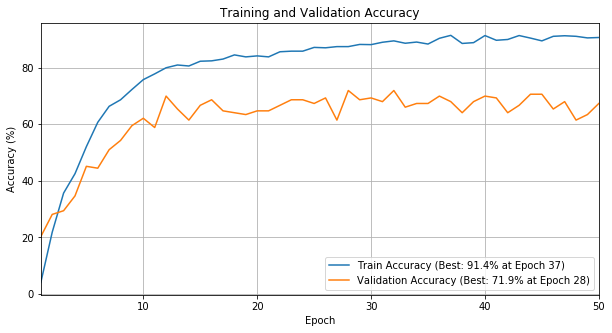

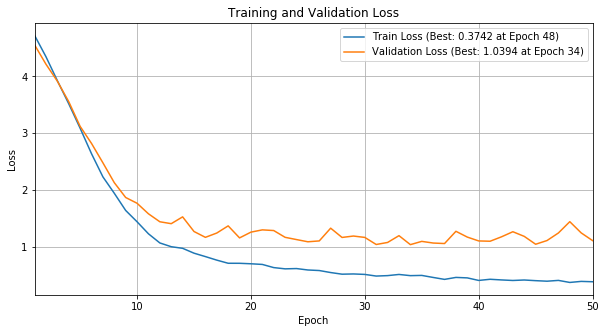

In [56]:
name = "model_only_leaky_relu"
log_file = name + '.txt'
plot_accuracy(log_file)
plot_loss(log_file)

In [23]:
name = "model_only_dropout"
model_path = name + '.pth'
log_file = name + '.txt'
model_only_dropout = DogBreedCNN(num_breeds=NUM_BREEDS, use_seblock=False, use_leaky_relu=False, use_dropout=True).to(device)
trained_model = train_model(model_only_dropout, device, train_loader, val_loader, num_epochs, lr, model_path, patience, log_file_path=log_file)

Epoch 1/50 - Train Loss: 4.7576, Train Acc: 2.31% - Val Loss: 4.4435, Val Acc: 14.38%
Training loss decreased. Saving model ...
Epoch 2/50 - Train Loss: 4.2826, Train Acc: 13.28% - Val Loss: 4.0901, Val Acc: 20.92%
Training loss decreased. Saving model ...
Epoch 3/50 - Train Loss: 3.8387, Train Acc: 30.82% - Val Loss: 3.6822, Val Acc: 39.22%
Training loss decreased. Saving model ...
Epoch 4/50 - Train Loss: 3.4310, Train Acc: 41.44% - Val Loss: 3.3539, Val Acc: 43.14%
Training loss decreased. Saving model ...
Epoch 5/50 - Train Loss: 3.0082, Train Acc: 50.03% - Val Loss: 3.0266, Val Acc: 45.75%
Training loss decreased. Saving model ...
Epoch 6/50 - Train Loss: 2.6422, Train Acc: 53.81% - Val Loss: 2.7097, Val Acc: 49.02%
Training loss decreased. Saving model ...
Epoch 7/50 - Train Loss: 2.3151, Train Acc: 58.14% - Val Loss: 2.4772, Val Acc: 47.71%
Training loss decreased. Saving model ...
Epoch 8/50 - Train Loss: 2.0329, Train Acc: 63.52% - Val Loss: 2.2575, Val Acc: 53.59%
Training lo

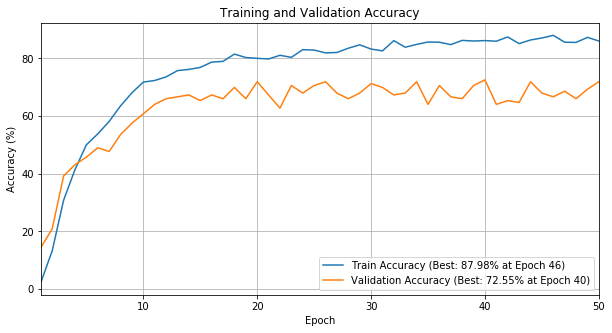

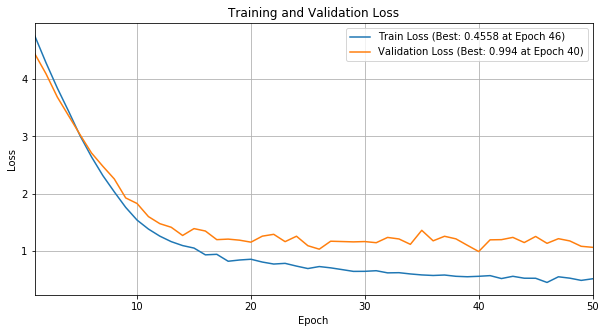

In [57]:
name = "model_only_dropout"
log_file = name + '.txt'
plot_accuracy(log_file)
plot_loss(log_file)

In [24]:
name = "model_only_seblock"
model_path = name + '.pth'
log_file = name + '.txt'
model_only_seblock = DogBreedCNN(num_breeds=NUM_BREEDS, use_seblock=True, use_leaky_relu=False, use_dropout=False).to(device)
trained_model = train_model(model_only_seblock, device, train_loader, val_loader, num_epochs, lr, model_path, patience, log_file_path=log_file)

Epoch 1/50 - Train Loss: 4.7194, Train Acc: 2.87% - Val Loss: 4.5410, Val Acc: 13.07%
Training loss decreased. Saving model ...
Epoch 2/50 - Train Loss: 4.3720, Train Acc: 20.75% - Val Loss: 4.2730, Val Acc: 23.53%
Training loss decreased. Saving model ...
Epoch 3/50 - Train Loss: 3.9977, Train Acc: 35.50% - Val Loss: 3.9851, Val Acc: 26.14%
Training loss decreased. Saving model ...
Epoch 4/50 - Train Loss: 3.4904, Train Acc: 45.35% - Val Loss: 3.3883, Val Acc: 38.56%
Training loss decreased. Saving model ...
Epoch 5/50 - Train Loss: 2.8329, Train Acc: 55.97% - Val Loss: 2.7488, Val Acc: 49.02%
Training loss decreased. Saving model ...
Epoch 6/50 - Train Loss: 2.1998, Train Acc: 64.78% - Val Loss: 2.1614, Val Acc: 58.82%
Training loss decreased. Saving model ...
Epoch 7/50 - Train Loss: 1.6669, Train Acc: 72.75% - Val Loss: 1.9348, Val Acc: 59.48%
Training loss decreased. Saving model ...
Epoch 8/50 - Train Loss: 1.3294, Train Acc: 76.59% - Val Loss: 1.5980, Val Acc: 61.44%
Training lo

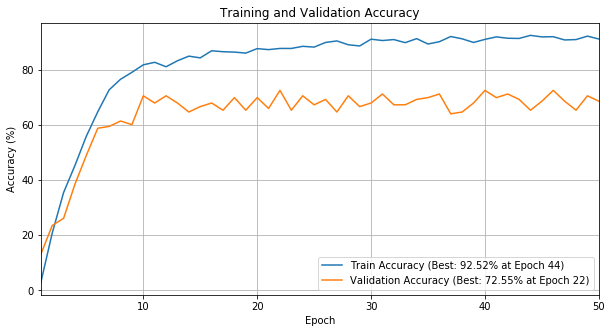

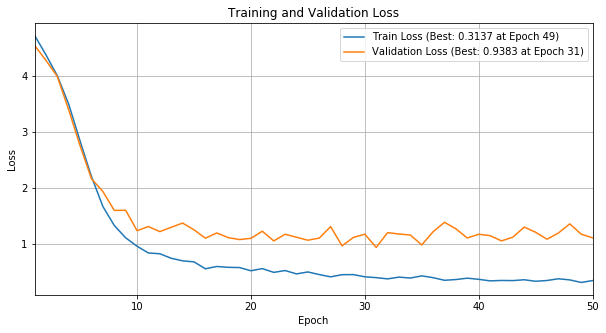

In [58]:
name = "model_only_seblock"
log_file = name + '.txt'
plot_accuracy(log_file)
plot_loss(log_file)

In [25]:
name = "model_basic"
model_path = name + '.pth'
log_file = name + '.txt'
model_basic = DogBreedCNN(num_breeds=NUM_BREEDS, use_seblock=False, use_leaky_relu=False, use_dropout=False).to(device)
trained_model = train_model(model_basic, device, train_loader, val_loader, num_epochs, lr, model_path, patience, log_file_path=log_file)

Epoch 1/50 - Train Loss: 4.6808, Train Acc: 6.01% - Val Loss: 4.3617, Val Acc: 20.26%
Training loss decreased. Saving model ...
Epoch 2/50 - Train Loss: 4.0706, Train Acc: 27.81% - Val Loss: 3.9122, Val Acc: 29.41%
Training loss decreased. Saving model ...
Epoch 3/50 - Train Loss: 3.5573, Train Acc: 44.37% - Val Loss: 3.3945, Val Acc: 44.44%
Training loss decreased. Saving model ...
Epoch 4/50 - Train Loss: 2.9954, Train Acc: 55.77% - Val Loss: 2.9549, Val Acc: 49.02%
Training loss decreased. Saving model ...
Epoch 5/50 - Train Loss: 2.4990, Train Acc: 62.26% - Val Loss: 2.5923, Val Acc: 47.71%
Training loss decreased. Saving model ...
Epoch 6/50 - Train Loss: 2.0741, Train Acc: 66.46% - Val Loss: 2.3617, Val Acc: 50.33%
Training loss decreased. Saving model ...
Epoch 7/50 - Train Loss: 1.6876, Train Acc: 72.75% - Val Loss: 2.0186, Val Acc: 58.17%
Training loss decreased. Saving model ...
Epoch 8/50 - Train Loss: 1.4314, Train Acc: 77.36% - Val Loss: 1.7820, Val Acc: 64.05%
Training lo

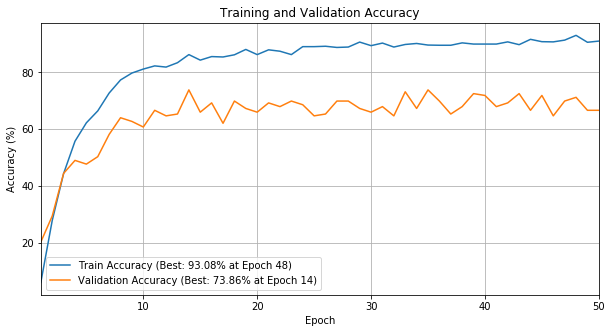

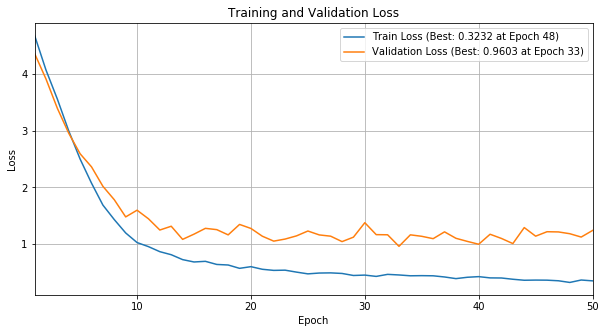

In [59]:
name = "model_basic"
log_file = name + '.txt'
plot_accuracy(log_file)
plot_loss(log_file)

### Ablation Studies
| Model                | Train Acc | Train Loss | Val Acc | Val Loss |
|----------------------|----------:|-----------:|--------:|---------:|
| All Features         |     85.19%|      0.5695|   73.20%|    0.9596|
| No LeakyReLU         |     87.91%|      0.4488|   76.47%|    0.9151|
| No Dropout           |     92.31%|      0.3331|   73.86%|    1.0204|
| No SEBlock           |     84.35%|      0.6025|   74.51%|    0.9919|
| Only LeakyReLU       |     91.40%|      0.3742|   71.90%|    1.0394|
| Only Dropout         |     87.98%|      0.4558|   72.55%|    0.9940|
| Only SEBlock         |     92.52%|      0.3137|   72.55%|    0.9383|
| Basic (No Features)  |     93.08%|      0.3232|   73.86%|    0.9603|


In my analysis of ablation studies of CNN models for dog breed classification, I have observed that the introduction or exclusion of features such as SEBlock, LeakyReLU, and Dropout significantly affects the performance of the model. My baseline model, "All Features", integrates all of these components, setting a standard in training and validation accuracy. I found that removing LeakyReLU improved both training and validation accuracy, suggesting that LeakyReLU has limited effectiveness in this particular scenario. On the other hand, the lack of Dropout significantly improves training accuracy but reduces validation accuracy, clearly demonstrating its critical role in mitigating overfitting. When I excluded SEBlock, the training accuracy decreased slightly but the validation accuracy increased, hinting at its contribution to model complexity and the overfitting problems it can cause. In configurations that used only one of these features, the validation performance of the model was generally lower compared to a baseline model that included all of the features. This highlights the synergistic effect of these features when used in combination. Finally, my "no feature base" model, while performing well in terms of training accuracy, did not perform as well on the validation set, highlighting the importance of advanced features in enhancing the generalization capabilities of a model. Through this research, I have recognized the complex interactions between individual network components and between them and overall model performance, highlighting the need for a balanced approach to feature integration.

### Visualization of results

In [26]:
# Function to visualize model predictions on validation data
def visualize_results(model, val_loader, breed_to_idx, row, col, device):
    model.eval() 
    idx_to_breed = {v: k for k, v in breed_to_idx.items()} 
    dataiter = iter(val_loader)
    images, labels = dataiter.next()
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)
    plt.figure(figsize=(15, (15/col) * row))
    for i in range(row * col):
        if i >= len(images):
            break
        plt.subplot(row, col, i + 1)
        img = images[i].cpu().numpy().transpose((1, 2, 0))
        img = np.clip(img, 0, 1)
        plt.imshow(img)
        actual_breed = idx_to_breed[labels[i].item()]
        predicted_breed = idx_to_breed[predicted[i].item()]
        color = 'green' if actual_breed == predicted_breed else 'red'
        plt.text(5, 30, f'GT:{actual_breed}', color='blue', fontsize=9, bbox=dict(facecolor='white', alpha=0.75))
        plt.text(5, 80, f'Pred:{predicted_breed}', color=color, fontsize=9, bbox=dict(facecolor='white', alpha=0.75))
        plt.axis('off')
    plt.show()

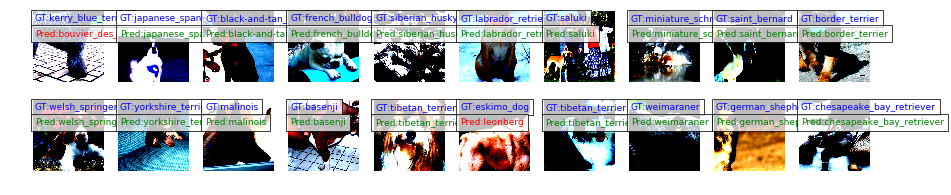

In [38]:
visualize_results(trained_model, val_loader, breed_to_idx, 2, 10, device)